In [1]:
from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Lambda, Flatten, Reshape, MaxPooling2D
from keras.models import Model
from keras.losses import mean_squared_error, kullback_leibler_divergence
from keras.callbacks import EarlyStopping, TerminateOnNaN, ReduceLROnPlateau
from keras import backend as K
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, scipy
from sklearn.model_selection import train_test_split

from phenom_to_df import *

Using TensorFlow backend.


In [2]:
#Get the data
df = csv_to_df('gam_samples/')

In [3]:
df = df.fillna(0)
variables = [entry for entry in df.columns if entry[0] == 'E'] + [entry for entry in df.columns if entry[0:2] == 'pt'] + [entry for entry in df.columns if entry[0:2] == 'et'] + [entry for entry in df.columns if entry[0:2] == 'ph']

In [4]:
df

,event_ID,process_ID,event_weight,MET,MET_Phi,obj1,E1,pt1,eta1,phi1,...,obj11,E11,pt11,eta11,phi11,obj12,E12,pt12,eta12,phi12
0,18984,2gam,1,42260.8,-1.43297,j,287062,248208,-0.548137,0.264839,...,0,0,0,0,0,0,0,0,0,0
1,18984,2gam,1,6035.72,1.96804,g,85958.2,23583.2,-1.9671,0.951141,...,0,0,0,0,0,0,0,0,0,0
2,18984,2gam,1,6622.72,-1.28153,g,33021.6,29679.4,-0.47023,1.32244,...,0,0,0,0,0,0,0,0,0,0
3,18984,2gam,1,6343.79,0.247373,g,30126.4,23789.3,0.714609,-2.42662,...,0,0,0,0,0,0,0,0,0,0
4,18984,2gam,1,8157.26,1.55667,g,100611,26763.5,1.99919,-2.17258,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1220762,26615,Wgam,1,1421.49,-2.474,j,204644,67794.3,1.76918,-0.687769,...,0,0,0,0,0,0,0,0,0,0
1220763,26615,Wgam,1,186690,0.211668,j,270526,142188,-1.25264,-2.68393,...,0,0,0,0,0,0,0,0,0,0
1220764,26615,Wgam,1,5755.02,-0.0294825,j,127753,56116.6,1.46162,2.70033,...,0,0,0,0,0,0,0,0,0,0
1220765,26615,Wgam,1,21209.7,1.45601,j,178814,69628,1.5946,-0.971769,...,0,0,0,0,0,0,0,0,0,0


In [5]:
#Now we one_hot encode the data to make sure we have a class definition
df = df[['process_ID']+variables]
one_hot = pd.get_dummies(df['process_ID'])
processes = one_hot.columns
df.drop('process_ID', axis = 'columns', inplace = True)
df = pd.concat([df, one_hot], sort = False, axis = 1)

/home/joe/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [6]:
#We have created a df of our values and some kind of class label
#We should normalize
x = df[variables].values
x_scaled = StandardScaler().fit_transform(x)
df[variables] = x_scaled

x_train, x_test, y_train, y_test = train_test_split(df[variables].values,
						    df[processes].values, 
                                                    shuffle = True,
                                                    random_state = 42,
                                                    test_size = 0.1)

In [7]:
#Reshape the data. This will have to be done explicitly until you think of a clever way of doing it
x_train = x_train.reshape((x_train.shape[0], 4, 3, 4))
x_test = x_test.reshape((x_test.shape[0], 4, 3, 4))

In [8]:
def sampling(args):
    z_mean, z_log_var=args
    epsilon=tf.random.uniform(shape=(K.shape(z_mean)[0], latent_dim))
    return z_mean+K.exp(z_log_var/2)*epsilon

In [9]:
#VAE Model
original_dim = x_train.shape[0]
input_shape = x_train.shape[1:]
latent_dim = 4
intermediate_dim = 50
kernel_max_norm = 1000.
act_fun = 'relu'
epsilon_std = 1.
filters = 32
kernel_size = (3, 3)
strides = (1, 1)


In [10]:
#Layers
x_input = Input(shape = input_shape, name = 'Input')
conv_1 = Conv2D(filters = filters, 
                activation = act_fun,
                kernel_size = kernel_size,
                strides = strides, 
                padding = 'same')(x_input)
pool_1 = MaxPooling2D(pool_size = (1, 1),
                      strides = 2,
                      data_format = 'channels_first')(conv_1)
conv_2 = Conv2D(filters = filters, 
                activation = act_fun, 
                kernel_size = kernel_size, 
                strides = strides, 
                padding = 'same')(pool_1)

#Shape info needed to inform the dense layer in the decoder
flatten = Flatten()(conv_2)
#cnn = Model(x_input, flatten, name = 'cnn')
#cnn.summary()

shape = input_shape

In [11]:
#Encoding
dense_encoder_1 = Dense(intermediate_dim,
                        activation = act_fun,
                        name = 'dense_encoder_1')(flatten)
dense_encoder_2 = Dense(16,
                        activation = act_fun,
                        name = 'dense_encoder_2')(dense_encoder_1)
z_mean = Dense(latent_dim, name = 'z_mean')(dense_encoder_2)
z_var = Dense(latent_dim, name = 'z_var')(dense_encoder_2)

z = Lambda(sampling, output_shape = (latent_dim, ), name = 'sampling')([z_mean, z_var])

encoder = Model(x_input, [z_mean, z_var, z], name = 'encoder')
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              (None, 4, 3, 4)      0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 4, 3, 32)     1184        Input[0][0]                      
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 4, 2, 16)     0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 4, 2, 32)     4640        max_pooling2d_1[0][0]            
____________________________________________________________________________________________

In [12]:
#Decoding
decoder_input = Input(shape = (latent_dim, ), name = 'decoder_input')
dense_decoder_1 = Dense(shape[0]*shape[1]*shape[2], 
                        activation = act_fun, name = 'dense_decoder_1')(decoder_input)
reshape = Reshape((shape[0], shape[1], shape[2]))(dense_decoder_1)

deconv_1 = Conv2DTranspose(filters = filters,
                           kernel_size = kernel_size, 
                           activation = act_fun, 
                           strides = strides, 
                           padding = 'same', 
                           name = 'deconv_1')(reshape)
deconv_2 = Conv2DTranspose(filters = 16,
                           kernel_size = kernel_size, 
                           activation = act_fun, 
                           strides = strides, 
                           padding = 'same', 
                           name = 'deconv_2')(deconv_1)

output = Conv2DTranspose(filters = 4, 
                         kernel_size = kernel_size, 
                         activation = 'sigmoid', 
                         padding = 'same', 
                         strides = strides, 
                         name = 'decoder_output')(deconv_2)

decoder = Model(decoder_input, output, name = 'decoder')
decoder.summary()


Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 4)                 0         
_________________________________________________________________
dense_decoder_1 (Dense)      (None, 48)                240       
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 3, 4)           0         
_________________________________________________________________
deconv_1 (Conv2DTranspose)   (None, 4, 3, 32)          1184      
_________________________________________________________________
deconv_2 (Conv2DTranspose)   (None, 4, 3, 16)          4624      
_________________________________________________________________
decoder_output (Conv2DTransp (None, 4, 3, 4)           580       
Total params: 6,628
Trainable params: 6,628
Non-trainable params: 0
_________________________________________________________

In [13]:
#Build the VAE model
outputs = decoder(encoder(x_input)[2])
vae = Model(x_input, outputs, name = 'vae')

In [14]:
#Define some losses
def kl_loss(y_true, y_pred):
    kl_loss = 1 + z_var - K.square(z_mean) - K.exp(z_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    kl_loss = K.mean(kl_loss)
    return kl_loss

def recon_loss(y_true, y_pred):
    recon_loss = mean_squared_error(K.flatten(y_true), K.flatten(y_pred))
    recon_loss *= shape[0]*shape[1]*shape[2]
    recon_loss = K.mean(recon_loss)
    return recon_loss

def my_vae_loss(y_true, y_pred):
    recon = recon_loss(y_true, y_pred) 
    kl = kl_loss(y_true, y_pred)
    vae_loss = recon + kl
    return vae_loss


In [15]:
vae.summary()

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 4, 3, 4)           0         
_________________________________________________________________
encoder (Model)              [(None, 4), (None, 4), (N 19626     
_________________________________________________________________
decoder (Model)              (None, 4, 3, 4)           6628      
Total params: 26,254
Trainable params: 26,254
Non-trainable params: 0
_________________________________________________________________


In [16]:
vae.compile(optimizer = 'rmsprop', loss = my_vae_loss, metrics = [kl_loss, recon_loss])
vae.summary()


Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 4, 3, 4)           0         
_________________________________________________________________
encoder (Model)              [(None, 4), (None, 4), (N 19626     
_________________________________________________________________
decoder (Model)              (None, 4, 3, 4)           6628      
Total params: 26,254
Trainable params: 26,254
Non-trainable params: 0
_________________________________________________________________


In [17]:
#Fit the model
epochs = 100
batch_size = 1000

history = vae.fit(x = x_train,
                  y = x_train,
                  validation_data = (x_test, x_test),
                  epochs = epochs,
                  batch_size = batch_size,
                  verbose = 2, 
                 callbacks = [TerminateOnNaN(), ReduceLROnPlateau(), EarlyStopping()])

vae.save('cnn-vae_model.h5')

Train on 1098690 samples, validate on 122077 samples
Epoch 1/100
 - 50s - loss: 45.4371 - kl_loss: 0.4045 - recon_loss: 45.0290 - val_loss: 36.0624 - val_kl_loss: 0.5234 - val_recon_loss: 35.3903
Epoch 2/100
 - 60s - loss: 44.1258 - kl_loss: 0.5625 - recon_loss: 43.5563 - val_loss: 35.4694 - val_kl_loss: 0.6266 - val_recon_loss: 34.6936
Epoch 3/100
 - 62s - loss: 43.7175 - kl_loss: 0.6192 - recon_loss: 43.0923 - val_loss: 35.2114 - val_kl_loss: 0.5994 - val_recon_loss: 34.4643
Epoch 4/100
 - 54s - loss: 43.5488 - kl_loss: 0.6404 - recon_loss: 42.9057 - val_loss: 35.1420 - val_kl_loss: 0.6690 - val_recon_loss: 34.3250
Epoch 5/100
 - 53s - loss: 43.4499 - kl_loss: 0.6542 - recon_loss: 42.7914 - val_loss: 35.0525 - val_kl_loss: 0.6401 - val_recon_loss: 34.2651
Epoch 6/100
 - 53s - loss: 43.3737 - kl_loss: 0.6673 - recon_loss: 42.7009 - val_loss: 35.0054 - val_kl_loss: 0.6551 - val_recon_loss: 34.2040
Epoch 7/100
 - 55s - loss: 43.3180 - kl_loss: 0.6854 - recon_loss: 42.6314 - val_loss: 34

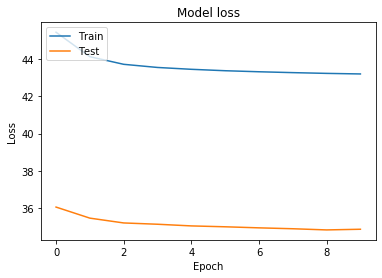

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [19]:
vae.metrics_names

['loss', 'kl_loss', 'recon_loss']

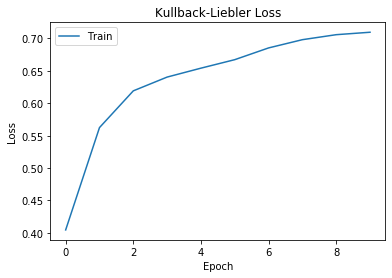

In [20]:
plt.plot(history.history['kl_loss'])
plt.title('Kullback-Liebler Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.show()

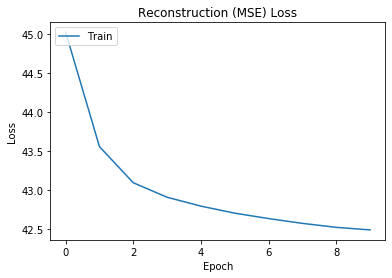

In [21]:
plt.plot(history.history['recon_loss'])
plt.title('Reconstruction (MSE) Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.show()

In [ ]:
anom_df = csv_to_df('bsm_test/')

In [ ]:
anom_df = anom_df.fillna(0)
anom_vars = [entry for entry in df.columns if entry[0] == 'E'] + [entry for entry in df.columns if entry[0:2] == 'pt'] + [entry for entry in df.columns if entry[0:2] == 'et'] + [entry for entry in df.columns if entry[0:2] == 'ph']
#Now we one_hot encode the data to make sure we have a class definition
anom_df = anom_df[['process_ID']+anom_vars]
anom_one_hot = pd.get_dummies(anom_df['process_ID'])
anom_processes = anom_one_hot.columns
anom_df.drop('process_ID', axis = 'columns', inplace = True)
anom_df = pd.concat([anom_df, anom_one_hot], sort = False, axis = 1)

In [ ]:
#We have created a df of our values and some kind of class label
#We should normalize
anom_x = anom_df[anom_vars].values
anom_scaled = StandardScaler().fit_transform(anom_x)
anom_df[anom_vars] = anom_scaled

anom_x_train, anom_x_test, anom_y_train, anom_y_test = train_test_split(anom_df[anom_vars].values,
						    anom_df[anom_processes].values, 
                                                    shuffle = True,
                                                    random_state = 42,
                                                    test_size = 0.1)

In [ ]:
#Reshape the data. This will have to be done explicitly until you think of a clever way of doing it
anom_x_train = anom_x_train.reshape((anom_x_train.shape[0], 4, 3, 5))
anom_x_test = anom_x_test.reshape((anom_x_test.shape[0], 4, 3, 5))

In [ ]:
from keras.models import load_model

In [ ]:
vae.evaluate(x_train[:2455], anom_x_train)